In [1]:
import librosa
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
import noisereduce as nr

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_audio_path = "../Dataset/01.Ha\'/Ha\'_M1_11.wav"

In [3]:
ipd.Audio(sample_audio_path)

In [4]:
y, sample_rate = librosa.load(sample_audio_path, sr=44100)
print('sample rate: ', sample_rate)
print('y shape : ', y.shape)

sample rate:  44100
y shape :  (543312,)


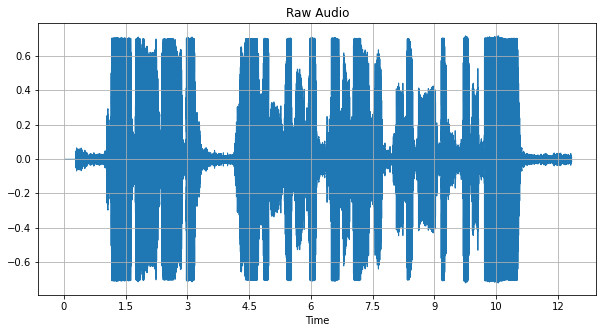

In [5]:
fig = plt.figure(figsize = (10,5))
fig.patch.set_facecolor('white')
librosa.display.waveshow(y , sr=sample_rate)
plt.title('Raw Audio')
plt.grid(True)
plt.show()

In [6]:
# trimmed 
y, _ = librosa.effects.trim(y, top_db=20)
print(y.shape)

(444928,)


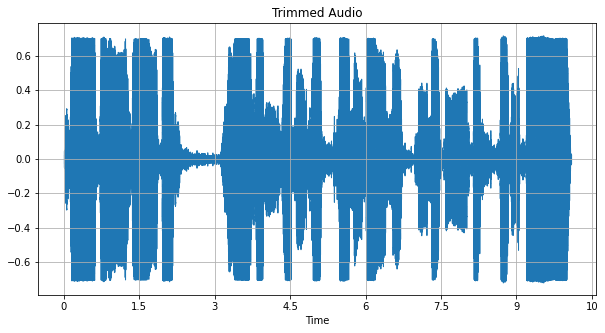

In [7]:
fig = plt.figure(figsize = (10,5))
fig.patch.set_facecolor('white')
librosa.display.waveshow(y , sr=sample_rate)
plt.title('Trimmed Audio')
plt.grid(True)
plt.show()

In [8]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

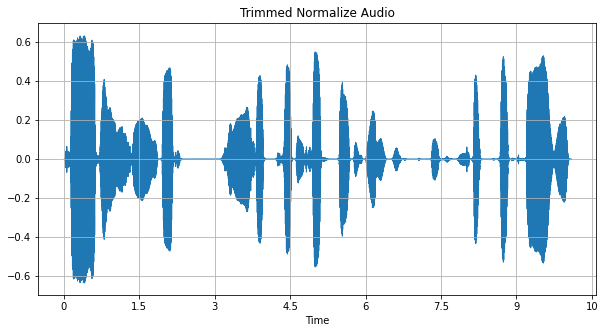

In [9]:
y = nr.reduce_noise(y, sample_rate)
# y = normalize_audio(y)
fig = plt.figure(figsize = (10,5))
fig.patch.set_facecolor('white')
librosa.display.waveshow(y , sr=sample_rate)
plt.title('Trimmed Normalize Audio')
plt.grid(True)
plt.show()

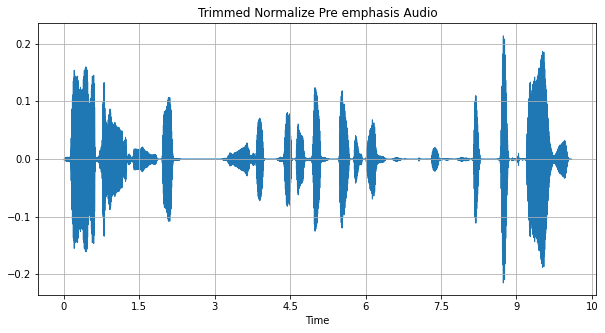

In [10]:
y = librosa.effects.preemphasis(y)
fig = plt.figure(figsize = (10,5))
fig.patch.set_facecolor('white')
librosa.display.waveshow(y , sr=sample_rate)
plt.title('Trimmed Normalize Pre emphasis Audio')
plt.grid(True)
plt.show()

In [11]:
def frame_audio(audio, FFT_size=1024, hop_size=15, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [12]:
hop_size = 12 #ms
FFT_size = 1024

audio_framed = frame_audio(y, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (842, 1024)


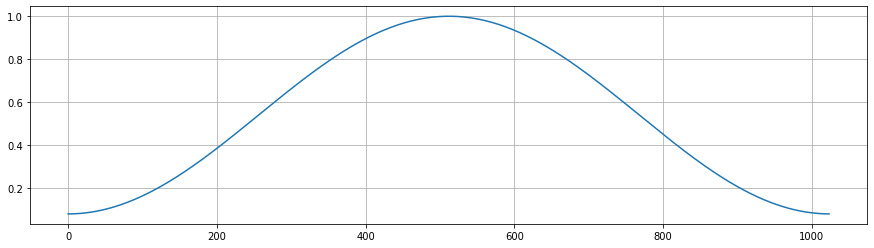

In [13]:
window = get_window("hamming", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)
plt.gcf().patch.set_facecolor('white')
plt.show()

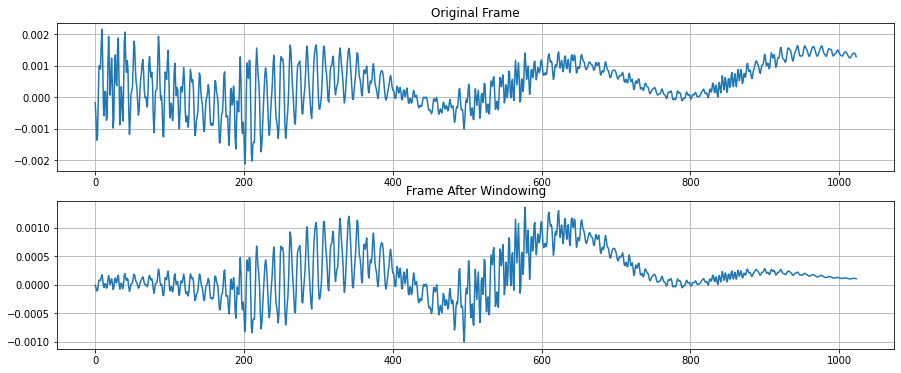

In [14]:
audio_win = audio_framed * window

ind = 400
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

plt.gcf().patch.set_facecolor('white')
plt.show()

In [15]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [16]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(842, 513)


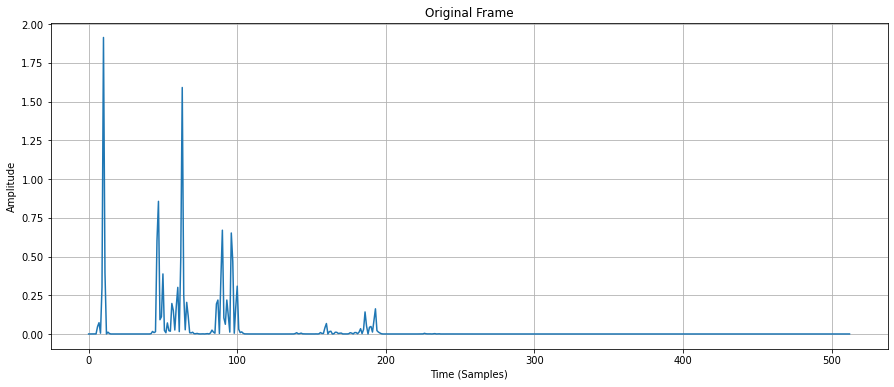

In [43]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('white')
plt.plot(audio_power[100])
plt.title('Original Frame')
plt.xlabel('Time (Samples)')  # Menambah label sumbu x
plt.ylabel('Amplitude')  # Menambah label sumbu y
plt.grid(True)
plt.show()

In [17]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 20

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [18]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [19]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 0.5) / sample_rate * freqs).astype(int), freqs

In [20]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([  0,   2,   6,  10,  15,  20,  27,  35,  44,  56,  69,  84, 102,
       124, 149, 179, 214, 256, 305, 363, 431, 512])

In [21]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

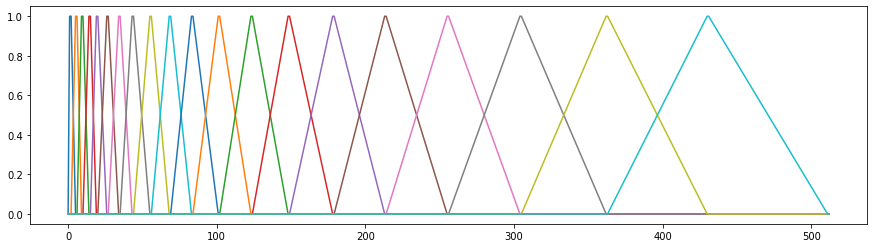

In [22]:
filters = get_filters(filter_points, FFT_size)

fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('white')
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [23]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

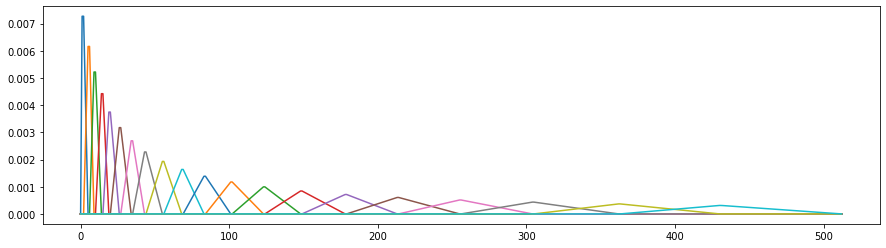

In [24]:

fig = plt.figure(figsize=(15,4))
fig.patch.set_facecolor('white')
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [25]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(20, 842)

In [26]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [27]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(13, 842)

In [28]:
cepstral_coefficents[:, 0]

array([-315.30532675,    4.25638302,   -2.72080257,    8.33716068,
         11.11526662,    1.35241732,    4.25640801,   10.77325803,
          5.37891261,    0.63920373,    4.80275398,    6.18301284,
          2.36217817])

In [29]:
print(type(cepstral_coefficents))

<class 'numpy.ndarray'>


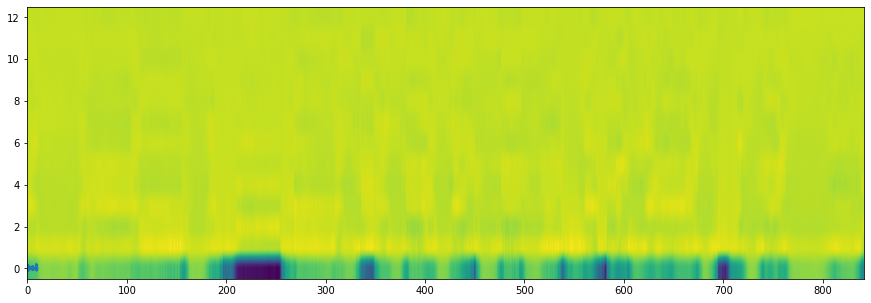

In [30]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('white')
plt.plot(np.linspace(0, len(y) / sample_rate, num=len(y)), y)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

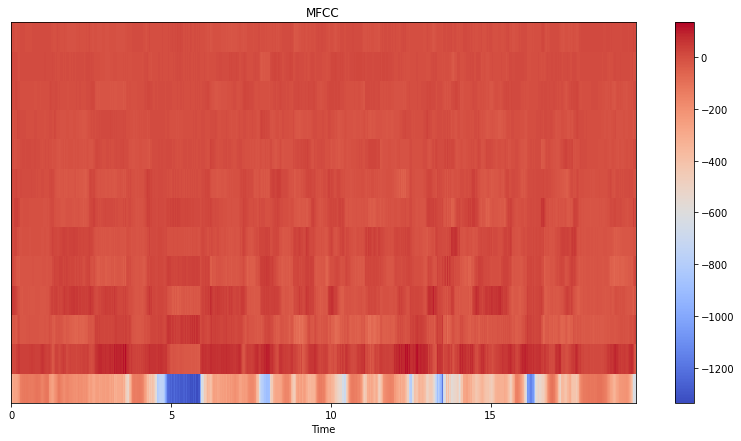

In [31]:
fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('white')
librosa.display.specshow(cepstral_coefficents, x_axis='time')
plt.title('MFCC')
plt.colorbar()
plt.show()

In [32]:
print(cepstral_coefficents.shape)

(13, 842)


In [33]:
norm_mfccs = librosa.util.normalize(cepstral_coefficents)

In [34]:
norm_mfccs

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 1.34992423e-02,  8.14212840e-02,  4.67127821e-02, ...,
         6.61179038e-02, -2.35498331e-02, -4.98162634e-02],
       [-8.62910436e-03, -5.91591059e-02, -9.06178835e-02, ...,
        -4.38080542e-04,  2.00156769e-02,  4.44540946e-02],
       ...,
       [ 1.52320737e-02,  1.59219482e-02,  3.15307527e-02, ...,
         6.14207273e-03,  7.71813831e-03,  2.02558351e-02],
       [ 1.96096048e-02,  3.94577320e-02,  5.01653005e-02, ...,
        -1.26369688e-02, -6.59354672e-03, -1.20966560e-02],
       [ 7.49171666e-03,  1.76903067e-03,  3.85987352e-03, ...,
         2.27807533e-02,  6.27706356e-03,  1.63653604e-02]])

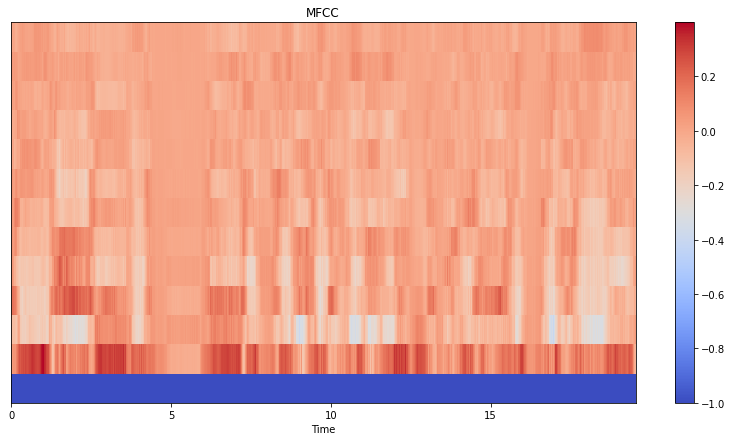

In [35]:
fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('white')
librosa.display.specshow(norm_mfccs, x_axis='time')
plt.title('MFCC')
plt.colorbar()
plt.show()